## Importing libraries

In [12]:
import torch
import torchvision
import numpy as np
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

## Importing data

Downloading dataset applying transformation

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='../Data', train=True,
                                        download = True, transform = transform)
testset = torchvision.datasets.CIFAR10(root='../Data', train=False,
                                       download = True, transform = transform)

Files already downloaded and verified
Files already downloaded and verified


Loading dataset

In [13]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 4, shuffle = True, num_workers = 2)
testloader = torch.utils.data.DataLoader(testset, batch_size = 4, shuffle = False, num_workers = 2)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

## Processing data

Displaying data

In [6]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [7]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

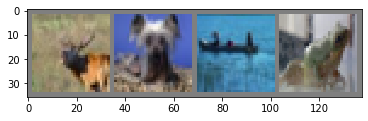

      deer       dog      ship      frog


In [8]:
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print('     '+'     '.join('%5s' % classes[labels[j]] for j in range(4)))


# Building model

In [18]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        ## Defining networt
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        ## Defining optimizer and loss function
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.SGD(self.parameters(), lr = 0.001, momentum = 0.9)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def train(self, traindata, numberEpoch = 5):
        
        for epoch in range(numberEpoch):  # loop over the dataset multiple times
            running_loss = 0.0
            count = 0
            pbar = tqdm(enumerate(traindata, 0), total = 12500, desc = "Loss 0, Completed", ncols = 800)
            for i, data in pbar:
                # get the inputs; data is a list of [inputs, labels]
                inputs, labels = data[0].to(device), data[1].to(device)


                # zero the parameter gradients
                self.optimizer.zero_grad()

                # forward + backward + optimize
                outputs = self.forward(inputs)
#                 print(outputs)
#                 print(labels)
                break
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()

                # print statistics
                running_loss += loss.item()
                count += 1
                pbar.set_description("Loss %.3f, Completed" %(running_loss/count))
            print('Epoch %d completed, average loss: %.3f' %(epoch + 1, running_loss / count))
        print('Finished Training')
            
    def predict(self, image):
        image = image.to(device)
        channel, height, width = image.size()
        outputs = self.forward(image.view(1, channel, height, width))
        prediction = torch.max(outputs, 1)[1]
        return classes[prediction]
                                  
    def evaluate(self, testdata):
        correct = 0
        total = 0
        with torch.no_grad():
            for data in testdata:
                images, labels = data
                images = images.to(device)
                labels = labels.to(device)
                outputs = self(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        print('Accuracy of the network on the images: %d %%' % (100 * correct / total))

Enebleing cuda

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Net()
model.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (criterion): CrossEntropyLoss()
)

In [20]:
model.train(trainloader, numberEpoch = 10)

tensor([[-0.0599, -0.0856, -0.0185, -0.0894,  0.0928,  0.0506, -0.0064, -0.0247,
         -0.0794, -0.1346],
        [-0.0621, -0.0766, -0.0325, -0.1023,  0.0644,  0.0311, -0.0100, -0.0064,
         -0.0629, -0.1340],
        [-0.0573, -0.0793, -0.0177, -0.1175,  0.0838,  0.0429,  0.0034, -0.0195,
         -0.0699, -0.1404],
        [-0.0495, -0.0852, -0.0187, -0.1003,  0.0851,  0.0432,  0.0021, -0.0204,
         -0.0732, -0.1391]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([3, 5, 1, 1], device='cuda:0')


ZeroDivisionError: float division by zero

## Saving and loading model

Saving

In [10]:
PATH = '../Output/ModelWeight/weights2'
# torch.save(model.state_dict(), PATH)

Loading

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Net()
model.to(device)
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

## Evaluation

Training data

In [121]:
model.evaluate(trainloader)

Accuracy of the network on the 10000 test images: 72 %


Test data

In [125]:
model.evaluate(testloader)

Accuracy of the network on the test images: 61 %


## Loading the model

In [12]:
model.evaluate(trainloader)

Accuracy of the network on the images: 50 %


## Rough

In [16]:
for i, d in enumerate(trainloader, 0):
    label = d[1]
    print(label)
    break

tensor([7, 6, 9, 6])
